In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

# Catfish Sales Data

In [74]:
#read data
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

weekly_conn = pd.read_csv('../../device_simulation/weekDist.csv', usecols = ['time','num_usr'], parse_dates=[0], index_col=0, date_parser=parser)
weekly_conn

,num_usr
time,
2022-06-10 00:00:00,70
2022-06-10 01:00:00,48
2022-06-10 02:00:00,45
2022-06-10 03:00:00,38
2022-06-10 04:00:00,35
...,...
2022-06-16 19:00:00,104
2022-06-16 20:00:00,110
2022-06-16 21:00:00,112


In [105]:
weekly_conn = weekly_conn.squeeze().astype(int)

In [106]:
#infer the frequency of the data
weekly_conn = weekly_conn.asfreq(pd.infer_freq(weekly_conn.index))
weekly_conn

time
2022-06-10 00:00:00     70
2022-06-10 01:00:00     48
2022-06-10 02:00:00     45
2022-06-10 03:00:00     38
2022-06-10 04:00:00     35
                      ... 
2022-06-16 19:00:00    104
2022-06-16 20:00:00    110
2022-06-16 21:00:00    112
2022-06-16 22:00:00    108
2022-06-16 23:00:00     80
Freq: H, Name: num_usr, Length: 168, dtype: int64

In [107]:
start_date = datetime(2022, 6, 10, 0, 0, 0)
end_date = datetime(2022, 6, 13, 0, 0, 0)

train_weekly_conn = weekly_conn[start_date:end_date]
train_weekly_conn

time
2022-06-10 00:00:00     70
2022-06-10 01:00:00     48
2022-06-10 02:00:00     45
2022-06-10 03:00:00     38
2022-06-10 04:00:00     35
                      ... 
2022-06-12 20:00:00    108
2022-06-12 21:00:00    106
2022-06-12 22:00:00     94
2022-06-12 23:00:00     74
2022-06-13 00:00:00     59
Freq: H, Name: num_usr, Length: 73, dtype: int64

Text(0, 0.5, 'Number of connected devices')

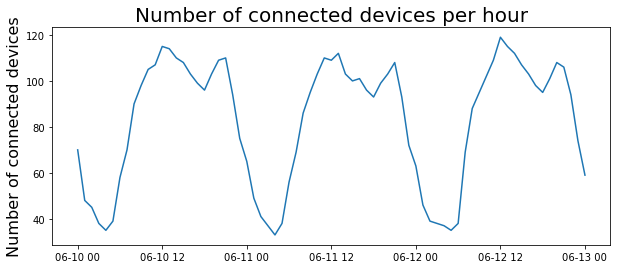

In [108]:
plt.figure(figsize=(10,4))
plt.plot(train_weekly_conn)
plt.title('Number of connected devices per hour', fontsize=20)
plt.ylabel('Number of connected devices', fontsize=16)

## Remove the trend

In [109]:
first_diff = train_weekly_conn.diff()[1:]
first_diff.shape

(72,)

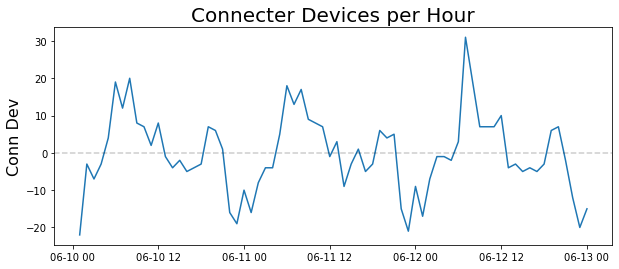

In [110]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Connecter Devices per Hour', fontsize=20)
plt.ylabel('Conn Dev', fontsize=16)

plt.axhline(0, color='k', linestyle='--', alpha=0.2)

# ACF

In [111]:
acf_vals = acf(first_diff)
acf_vals.shape

(19,)

<BarContainer object of 19 artists>

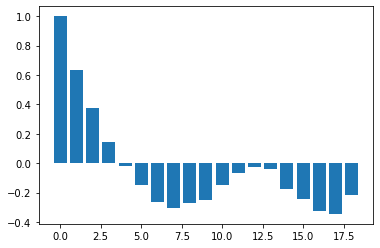

In [112]:
num_lags = 19
plt.bar(range(num_lags), acf_vals[:num_lags])

## Based on ACF, we should start with a seasonal MA process

# PACF

<BarContainer object of 15 artists>

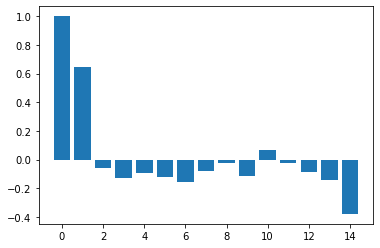

In [113]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Based on PACF, we should start with a seasonal AR process

# Get training and testing sets

In [114]:
weekly_conn

time
2022-06-10 00:00:00     70
2022-06-10 01:00:00     48
2022-06-10 02:00:00     45
2022-06-10 03:00:00     38
2022-06-10 04:00:00     35
                      ... 
2022-06-16 19:00:00    104
2022-06-16 20:00:00    110
2022-06-16 21:00:00    112
2022-06-16 22:00:00    108
2022-06-16 23:00:00     80
Freq: H, Name: num_usr, Length: 168, dtype: int64

In [115]:

train_end = datetime(2022, 6, 14, 0, 0, 0)
test_end = datetime(2022, 6, 16, 23, 0, 0)

train_data = weekly_conn[:train_end]
test_data = weekly_conn[train_end + timedelta(hours=1):test_end]

# Fit the SARIMA Model

In [137]:
my_order = (0,1,1)
my_seasonal_order = (1, 1, 1, 24)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [138]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55084D+00    |proj g|=  4.42660D-02


 This problem is unconstrained.



At iterate    5    f=  2.52850D+00    |proj g|=  9.51714D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   1.954D-06   2.528D+00
  F =   2.5284969133890414     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model Fitting Time: 0.6777255535125732


In [139]:
#summary of the model
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            num_usr   No. Observations:                  167
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 24)   Log Likelihood                -422.259
Date:                            Tue, 02 Aug 2022   AIC                            852.518
Time:                                    10:50:37   BIC                            864.341
Sample:                                06-10-2022   HQIC                           857.322
                                     - 06-16-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3994      0.062     -6.454      0.000      -0.521      -0.278
ar.S.L24      -0.4831      0.132   

In [140]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
predictions = predictions.squeeze()
residuals = test_data - predictions

Text(0, 0.5, 'Error')

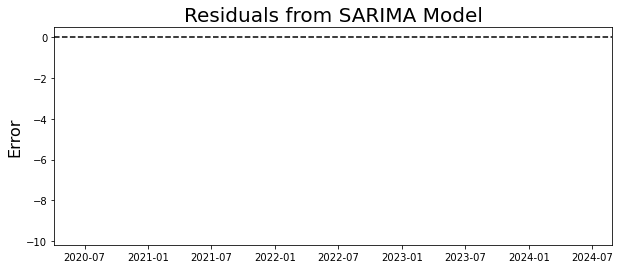

In [141]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

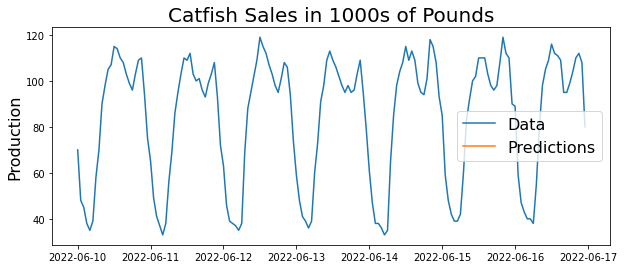

In [142]:
plt.figure(figsize=(10,4))

plt.plot(weekly_conn)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [143]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.1212


In [144]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 9.693547094448661


# Using the Rolling Forecast Origin

In [145]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = weekly_conn[:train_end-timedelta(hours=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.27594D+00    |proj g|=  3.26857D-01

At iterate    5    f=  2.14082D+00    |proj g|=  6.16996D-02

At iterate   10    f=  2.11627D+00    |proj g|=  6.00077D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   6.817D-06   2.116D+00
  F =   2.1162664650298191     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  2.11744D+00    |proj g|=  1.90496D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   7.909D-06   2.117D+00
  F =   2.1174318352875172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19149D+00    |proj g|=  5.48974D-02

At iterate    5    f=  2.12179D+00    |proj g|=  9.70978D-03


 This problem is unconstrained.



At iterate   10    f=  2.12047D+00    |proj g|=  7.01916D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   8.525D-06   2.120D+00
  F =   2.1204699310657835     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20366D+00    |proj g|=  6.70412D-02

At iterate    5    f=  2.12530D+00    |proj g|=  1.21471D-02


/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   10    f=  2.12169D+00    |proj g|=  7.05716D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   6.688D-07   2.122D+00
  F =   2.1216788966357587     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20810D+00    |proj g|=  1.28702D-01

At iterate    5    f=  2.12420D+00    |proj g|=  9.79485D-03


/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   10    f=  2.12271D+00    |proj g|=  1.21553D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   3.163D-06   2.123D+00
  F =   2.1227138206147216     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21360D+00    |proj g|=  7.48315D-02

At iterate    5    f=  2.13067D+00    |proj g|=  1.08315D-02


/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   10    f=  2.12777D+00    |proj g|=  3.67951D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   2.756D-06   2.128D+00
  F =   2.1277742811398621     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.38530D+00    |proj g|=  4.03207D-01

At iterate    5    f=  2.22106D+00    |proj g|=  6.64178D-02


/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.



At iterate   10    f=  2.15809D+00    |proj g|=  1.36137D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   7.975D-07   2.158D+00
  F =   2.1580818696255091     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53509D+00    |proj g|=  2.25178D-01


 This problem is unconstrained.



At iterate    5    f=  2.22398D+00    |proj g|=  2.17444D-02

At iterate   10    f=  2.19627D+00    |proj g|=  1.22589D-01

At iterate   15    f=  2.15925D+00    |proj g|=  1.19916D-02

At iterate   20    f=  2.15884D+00    |proj g|=  1.83569D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     29      1     0     0   1.836D-06   2.159D+00
  F =   2.1588427273450881     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate    5    f=  2.21630D+00    |proj g|=  3.13964D-02

At iterate   10    f=  2.19726D+00    |proj g|=  1.49088D-01

At iterate   15    f=  2.15971D+00    |proj g|=  5.46765D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   9.045D-06   2.160D+00
  F =   2.1596518051016891     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43210D+00    |proj g|=  2.00788D-01


/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate    5    f=  2.20412D+00    |proj g|=  4.66324D-02

At iterate   10    f=  2.17410D+00    |proj g|=  7.19731D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   3.036D-06   2.174D+00
  F =   2.1740891099131141     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58829D+00    |proj g|=  2.22244D-01

At iterate    5    f=  2.24411D+00    |proj g|=  1.43131D-02

At iterate   10    f=  2.24258D+00    |proj g|=  4.31163D-03

At iterate   15    f=  2.23191D+00    |proj g|=  1.50665D-01

At iterate   20    f=  2.17765D+00    |proj g|=  1.36839D-02

At iterate   25    f=  2.17651D+00    |proj g|=  2.69393D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     38      1     0     0   

/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate    5    f=  2.22418D+00    |proj g|=  1.96441D-02

At iterate   10    f=  2.17803D+00    |proj g|=  1.12076D-02

At iterate   15    f=  2.17705D+00    |proj g|=  1.58025D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     22      1     0     0   1.361D-06   2.177D+00
  F =   2.1770484025218058     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42633D+00    |proj g|=  1.96389D-01

At iter

/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   10    f=  2.17731D+00    |proj g|=  1.21879D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   9.869D-06   2.177D+00
  F =   2.1773086423923744     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42920D+00    |proj g|=  2.02211D-01


/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate    5    f=  2.19085D+00    |proj g|=  5.67198D-02

At iterate   10    f=  2.18023D+00    |proj g|=  2.12871D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   8.536D-06   2.180D+00
  F =   2.1801913023975534     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.49049D+00    |proj g|=  2.15878D-01


/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate    5    f=  2.23337D+00    |proj g|=  2.42554D-02

At iterate   10    f=  2.19351D+00    |proj g|=  2.99876D-02

At iterate   15    f=  2.19197D+00    |proj g|=  8.56506D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     26      1     0     0   5.320D-06   2.192D+00
  F =   2.1919688230053911     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.49717D+00    |proj g|=  2.15016D-01

At iter

/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   10    f=  2.19924D+00    |proj g|=  5.04777D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     23      1     0     0   8.578D-07   2.199D+00
  F =   2.1992354261080371     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47764D+00    |proj g|=  2.12469D-01

At iterate    5    f=  2.23870D+00    |proj g|=  2.75953D-02


/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   10    f=  2.21114D+00    |proj g|=  6.06389D-02

At iterate   15    f=  2.20311D+00    |proj g|=  2.52752D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     19      1     0     0   2.139D-05   2.203D+00
  F =   2.2031051343401460     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44662D+00    |proj g|=  1.96254D-01


/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate    5    f=  2.22650D+00    |proj g|=  7.53098D-02

At iterate   10    f=  2.20620D+00    |proj g|=  7.57493D-03

At iterate   15    f=  2.20568D+00    |proj g|=  1.28529D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     17      1     0     0   6.079D-06   2.206D+00
  F =   2.2056768621250495     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47523D+00    |proj g|=  2.05422D-01

At iterate    5    f=  2.23094D+00    |proj g|=  3.51869D-02

At iterate   10    f=  2.20611D+00    |proj g|=  2.18653D-02

At iterate   15    f=  2.20561D+00    |proj g|=  3.04793D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     22      1     0     0   1.024D-06   2.206D+00
  F =   2.2056149415784070     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate    5    f=  2.28709D+00    |proj g|=  8.47762D-02

At iterate   10    f=  2.20677D+00    |proj g|=  5.00580D-03

At iterate   15    f=  2.20669D+00    |proj g|=  1.26099D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   1.261D-06   2.207D+00
  F =   2.2066853095090502     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50869D+00    |proj g|=  2.05222D-01

At iterate    5    f=  2.27429D+00    |proj g|=  2.51666D-02

At iterate   10    f=  2.24996D+00    |proj g|=  1.80695D-02

At iterate   15    f=  2.24949D+00    |proj g|=  8.57949D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     20      1     0     0   8.579D-06   2.249D+00
  F =   2.2494938663760515     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate    5    f=  2.29483D+00    |proj g|=  1.23658D-02

At iterate   10    f=  2.27303D+00    |proj g|=  8.75950D-02

At iterate   15    f=  2.25518D+00    |proj g|=  1.91317D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   4.858D-06   2.255D+00
  F =   2.2551725618743643     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58940D+00    |proj g|=  2.18816D-01

At iter

/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   10    f=  2.31211D+00    |proj g|=  1.80703D-02

At iterate   15    f=  2.27219D+00    |proj g|=  1.84887D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   5.928D-06   2.271D+00
  F =   2.2711363497329207     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53009D+00    |proj g|=  2.15739D-01


/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate    5    f=  2.30917D+00    |proj g|=  1.71060D-02

At iterate   10    f=  2.29158D+00    |proj g|=  4.71414D-02

At iterate   15    f=  2.28517D+00    |proj g|=  3.11316D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     19      1     0     0   1.520D-06   2.285D+00
  F =   2.2851743832559763     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.56546D+00    |proj g|=  2.01673D-01

At iter

/home/paolo/miniconda3/envs/SARIMA/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.



At iterate   10    f=  2.32721D+00    |proj g|=  9.87982D-02

At iterate   15    f=  2.31418D+00    |proj g|=  1.20206D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   1.411D-06   2.314D+00
  F =   2.3141772254080983     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53896D+00    |proj g|=  1.91892D-01


 This problem is unconstrained.



At iterate    5    f=  2.34611D+00    |proj g|=  2.75908D-02

At iterate   10    f=  2.33541D+00    |proj g|=  6.75906D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   8.873D-07   2.335D+00
  F =   2.3354056277008102     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52782D+00    |proj g|=  1.82674D-01

At iterate    5    f=  2.36677D+00    |proj g|=  2.79044D-02

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   7.211D-06   2.349D+00
  F =   2.3486443228826044     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54423D+00    |proj g|=  1.81499D-01

At iterate    5    f=  2.38374D+00    |proj g|=  3.56331D-02


 This problem is unconstrained.



At iterate   10    f=  2.36286D+00    |proj g|=  1.96345D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     19      1     0     0   3.667D-06   2.363D+00
  F =   2.3628581809535421     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54634D+00    |proj g|=  1.71152D-01


 This problem is unconstrained.



At iterate    5    f=  2.39563D+00    |proj g|=  1.68190D-02

At iterate   10    f=  2.36992D+00    |proj g|=  3.67459D-02

At iterate   15    f=  2.36556D+00    |proj g|=  3.44625D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     25      1     0     0   8.799D-06   2.366D+00
  F =   2.3655620665988795     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52059D+00    |proj g|=  1.48747D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  2.37315D+00    |proj g|=  5.59066D-02

At iterate   15    f=  2.36681D+00    |proj g|=  3.20496D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   5.170D-06   2.367D+00
  F =   2.3668114286188664     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51579D+00    |proj g|=  1.56416D-01

At iterate    5    f=  2.41356D+00    |proj g|=  4.21753D-02


 This problem is unconstrained.



At iterate   10    f=  2.39596D+00    |proj g|=  2.20127D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     19      1     0     0   2.945D-07   2.395D+00
  F =   2.3950736527164787     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53064D+00    |proj g|=  1.66622D-01


 This problem is unconstrained.



At iterate    5    f=  2.41889D+00    |proj g|=  5.71280D-02

At iterate   10    f=  2.40163D+00    |proj g|=  1.42020D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   1.715D-06   2.401D+00
  F =   2.4012137481343210     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55208D+00    |proj g|=  1.58877D-01

At iterate    5    f=  2.42128D+00    |proj g|=  2.82307D-02


 This problem is unconstrained.



At iterate   10    f=  2.40271D+00    |proj g|=  2.80780D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     19      1     0     0   5.619D-07   2.403D+00
  F =   2.4026700517238386     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53962D+00    |proj g|=  1.66164D-01


 This problem is unconstrained.



At iterate    5    f=  2.42019D+00    |proj g|=  4.38700D-02

At iterate   10    f=  2.40305D+00    |proj g|=  7.69084D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   6.035D-06   2.403D+00
  F =   2.4029289158395142     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.49588D+00    |proj g|=  1.45071D-01

At iterate    5    f=  2.40491D+00    |proj g|=  1.80173D-02


 This problem is unconstrained.



At iterate   10    f=  2.40313D+00    |proj g|=  7.12610D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   5.285D-07   2.403D+00
  F =   2.4031299973203541     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54939D+00    |proj g|=  1.48182D-01


 This problem is unconstrained.



At iterate    5    f=  2.42537D+00    |proj g|=  2.35601D-02

At iterate   10    f=  2.41270D+00    |proj g|=  5.33826D-02

At iterate   15    f=  2.40436D+00    |proj g|=  1.05087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     22      1     0     0   6.997D-07   2.404D+00
  F =   2.4043618609167150     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47673D+00    |proj g|=  9.38272D-02


 This problem is unconstrained.



At iterate    5    f=  2.41242D+00    |proj g|=  7.09331D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     14      1     0     0   8.992D-06   2.412D+00
  F =   2.4122247239642327     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51276D+00    |proj g|=  1.61903D-01


 This problem is unconstrained.



At iterate    5    f=  2.42048D+00    |proj g|=  1.25143D-02

At iterate   10    f=  2.41882D+00    |proj g|=  8.35909D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     16      1     0     0   8.359D-07   2.419D+00
  F =   2.4188182239624885     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50988D+00    |proj g|=  1.55859D-01


 This problem is unconstrained.



At iterate    5    f=  2.42253D+00    |proj g|=  2.98102D-02

At iterate   10    f=  2.42090D+00    |proj g|=  4.70717D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   4.707D-06   2.421D+00
  F =   2.4208980211122357     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50381D+00    |proj g|=  1.42667D-01

At iterate    5    f=  2.42223D+00    |proj g|=  1.16364D-02

At iterate   10    f=  2.42152D+00    |proj g|=  8.76366D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     16      1     0     0   8.764D-07   2.422D+00
  F =   2.4215153414948198     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  2.42210D+00    |proj g|=  1.53030D-02

At iterate   10    f=  2.42146D+00    |proj g|=  7.30553D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     14      1     0     0   7.306D-06   2.421D+00
  F =   2.4214589607704124     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48772D+00    |proj g|=  9.10155D-02


 This problem is unconstrained.



At iterate    5    f=  2.42248D+00    |proj g|=  1.35762D-02

At iterate   10    f=  2.42196D+00    |proj g|=  2.89488D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     14      1     0     0   2.895D-06   2.422D+00
  F =   2.4219609509468745     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.49279D+00    |proj g|=  1.06103D-01


 This problem is unconstrained.



At iterate    5    f=  2.42480D+00    |proj g|=  1.28822D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     13      1     0     0   7.966D-06   2.424D+00
  F =   2.4244960192524427     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48846D+00    |proj g|=  4.98715D-02


 This problem is unconstrained.



At iterate    5    f=  2.43496D+00    |proj g|=  4.53854D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     13      1     0     0   4.982D-06   2.435D+00
  F =   2.4347992040633342     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48817D+00    |proj g|=  5.06688D-02


 This problem is unconstrained.



At iterate    5    f=  2.43653D+00    |proj g|=  5.08169D-03

At iterate   10    f=  2.43626D+00    |proj g|=  4.97571D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   4.976D-06   2.436D+00
  F =   2.4362557805812339     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.49355D+00    |proj g|=  5.04468D-02


 This problem is unconstrained.



At iterate    5    f=  2.44767D+00    |proj g|=  2.46668D-03

At iterate   10    f=  2.44763D+00    |proj g|=  3.33689D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   3.337D-07   2.448D+00
  F =   2.4476268210400041     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.49627D+00    |proj g|=  4.92804D-02


 This problem is unconstrained.



At iterate    5    f=  2.45501D+00    |proj g|=  1.88731D-03

At iterate   10    f=  2.45500D+00    |proj g|=  1.09508D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   1.095D-05   2.455D+00
  F =   2.4549994696350534     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.49941D+00    |proj g|=  4.82215D-02


 This problem is unconstrained.



At iterate    5    f=  2.45537D+00    |proj g|=  2.59669D-03

At iterate   10    f=  2.45528D+00    |proj g|=  3.36766D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     14      1     0     0   3.368D-06   2.455D+00
  F =   2.4552795569504875     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51178D+00    |proj g|=  5.30720D-02

At iterate    5    f=  2.47894D+00    |proj g|=  1.22461D-02

At iterate   10    f=  2.47861D+00    |proj g|=  4.75787D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   7.195D-07   2.479D+00
  F =   2.4786050962822710     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52194D+00    |proj g|=  1.16176D-01

At iterate    5    f=  2.48488D+00    |proj g|=  4.83693D-03

At iterate   10    f=  2.48459D+00    |proj g|=  6.49871D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   1.073D-06   2.485D+00
  F =   2.4845880888548990     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52243D+00    |proj g|=  1.10854D-01

At iterate    5    f=  2.48746D+00    |proj g|=  3.05176D-03

At iterate   10    f=  2.48732D+00    |proj g|=  1.03827D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   3.774D-06   2.487D+00
  F =   2.4873183408411905     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  2.48825D+00    |proj g|=  1.90971D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   1.280D-06   2.488D+00
  F =   2.4882465093905966     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51727D+00    |proj g|=  6.78811D-02


 This problem is unconstrained.



At iterate    5    f=  2.48845D+00    |proj g|=  2.73296D-03

At iterate   10    f=  2.48843D+00    |proj g|=  7.14680D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   2.913D-06   2.488D+00
  F =   2.4884338917922721     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51812D+00    |proj g|=  7.66363D-02


 This problem is unconstrained.



At iterate    5    f=  2.48843D+00    |proj g|=  4.28542D-03

At iterate   10    f=  2.48839D+00    |proj g|=  1.01419D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   5.404D-06   2.488D+00
  F =   2.4883865814764436     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52093D+00    |proj g|=  8.68910D-02


 This problem is unconstrained.



At iterate    5    f=  2.48985D+00    |proj g|=  4.22338D-03

At iterate   10    f=  2.48980D+00    |proj g|=  9.28567D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   8.350D-06   2.490D+00
  F =   2.4898033136443183     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53329D+00    |proj g|=  1.24311D-01


 This problem is unconstrained.



At iterate    5    f=  2.50091D+00    |proj g|=  8.14561D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   8.370D-06   2.501D+00
  F =   2.5009045184340493     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53209D+00    |proj g|=  1.17977D-01


 This problem is unconstrained.



At iterate    5    f=  2.50068D+00    |proj g|=  8.18304D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   7.638D-07   2.501D+00
  F =   2.5006773360918566     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54096D+00    |proj g|=  1.25303D-01


 This problem is unconstrained.



At iterate    5    f=  2.50734D+00    |proj g|=  1.02511D-03

At iterate   10    f=  2.50733D+00    |proj g|=  3.27569D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   3.276D-06   2.507D+00
  F =   2.5073259446066203     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54423D+00    |proj g|=  1.37870D-01


 This problem is unconstrained.



At iterate    5    f=  2.50830D+00    |proj g|=  1.65070D-03

At iterate   10    f=  2.50829D+00    |proj g|=  3.04701D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   1.670D-06   2.508D+00
  F =   2.5082876277020856     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54233D+00    |proj g|=  1.23666D-01

At iterate    5    f=  2.50871D+00    |proj g|=  2.38473D-03


 This problem is unconstrained.



At iterate   10    f=  2.50870D+00    |proj g|=  1.83622D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   1.013D-06   2.509D+00
  F =   2.5086992563732951     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53914D+00    |proj g|=  1.04716D-01


 This problem is unconstrained.



At iterate    5    f=  2.50845D+00    |proj g|=  4.25620D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   9.116D-06   2.508D+00
  F =   2.5084170742773879     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54000D+00    |proj g|=  1.07897D-01


 This problem is unconstrained.



At iterate    5    f=  2.50834D+00    |proj g|=  3.95354D-03

At iterate   10    f=  2.50831D+00    |proj g|=  2.12665D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   2.333D-06   2.508D+00
  F =   2.5083141347147158     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54024D+00    |proj g|=  1.00302D-01


 This problem is unconstrained.



At iterate    5    f=  2.50997D+00    |proj g|=  4.20710D-03

At iterate   10    f=  2.50995D+00    |proj g|=  8.28719D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   8.287D-06   2.510D+00
  F =   2.5099475017468733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54152D+00    |proj g|=  1.04595D-01


 This problem is unconstrained.



At iterate    5    f=  2.51031D+00    |proj g|=  3.80701D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   1.103D-05   2.510D+00
  F =   2.5102951325222578     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54527D+00    |proj g|=  9.90332D-02


 This problem is unconstrained.



At iterate    5    f=  2.51433D+00    |proj g|=  2.92813D-03

At iterate   10    f=  2.51432D+00    |proj g|=  1.37625D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   1.376D-05   2.514D+00
  F =   2.5143242606461293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54203D+00    |proj g|=  7.37716D-02

At iterate    5    f=  2.51415D+00    |proj g|=  3.00006D-03

At iterate   10    f=  2.51412D+00    |proj g|=  6.65836D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   6.658D-06   2.514D+00
  F =   2.5141203686414757     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  2.51577D+00    |proj g|=  3.06459D-03

At iterate   10    f=  2.51573D+00    |proj g|=  4.93166D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   4.932D-06   2.516D+00
  F =   2.5157341304506158     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54158D+00    |proj g|=  4.48301D-02


 This problem is unconstrained.



At iterate    5    f=  2.51617D+00    |proj g|=  3.40768D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     14      1     0     0   6.610D-06   2.516D+00
  F =   2.5161402618849564     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54956D+00    |proj g|=  4.24311D-02


 This problem is unconstrained.



At iterate    5    f=  2.52709D+00    |proj g|=  8.36949D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     12      1     0     0   4.798D-06   2.527D+00
  F =   2.5270913156044976     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55096D+00    |proj g|=  4.41366D-02


 This problem is unconstrained.



At iterate    5    f=  2.52845D+00    |proj g|=  3.08198D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   7.003D-06   2.528D+00
  F =   2.5284512029251522     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55084D+00    |proj g|=  4.42660D-02


 This problem is unconstrained.



At iterate    5    f=  2.52850D+00    |proj g|=  9.51714D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   1.954D-06   2.528D+00
  F =   2.5284969133890414     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [126]:
rolling_residuals = test_data - rolling_predictions

Text(0, 0.5, 'Error')

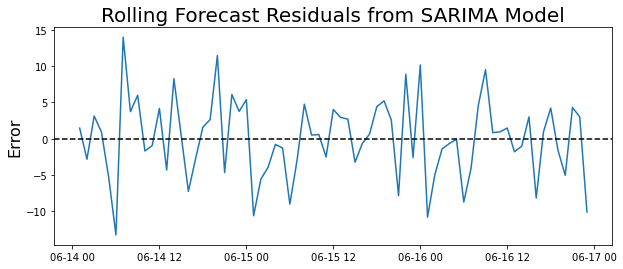

In [127]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

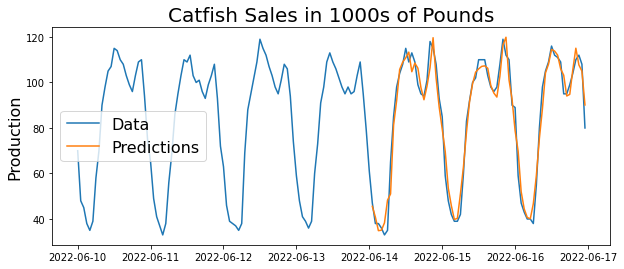

In [128]:
plt.figure(figsize=(10,4))

plt.plot(weekly_conn)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [129]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_data)),4))

Mean Absolute Percent Error: 0.0608


In [130]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 5.469079095897303
